<a href="https://colab.research.google.com/github/janbogar/czechitas-transformers/blob/main/czechitas-BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformers for text processing

Transformers are neural networks that changed how we model sequential data.

There are many kinds of data that are sequential in nature, for example time series, but i.e. text is also just a sequence of words.

State of the art in these areas used to be recurrent neural networks. They work by taking as an input not just an item in the sequence, but also the output of the network on the previous item. This way, the output of the network can contain the memmory of what happened previously.

The problem with recurrent neural networks was difficulty of training them in parallel. They also had trouble learning relationships between words that were far away from each other.

Transformers work quite differently. All of the sequence is shown to the network at once, and a special architecture called attention head (transformers usually have multiple) predict to which parts of sentence should the network pay attention when processing each word.

Famous transformer-based language models are e.g. BERT and GPT3, but there are many more variants, such as RoBERTa, ALBERT, or ELECTRA.

# Model
In this notebook we will use BERT model trained and published by researches at  West Bohemia University. The model is called Czert and the authors experimented with it on many tasks:
 - Sequence Classification (**Sentiment Classification**, Multi-label Document Classification)
 - Sequence Pair Classification (Semantic Text Similarity)
 -Token Classification (Morphological Tagging, Named Entity Recognition,
Semantic Role Labeling)

The model:
https://huggingface.co/UWB-AIR/Czert-B-base-cased

The paper:
https://arxiv.org/pdf/2103.13031.pdf

# Sentiment analysis

In this notebook, we will use the model trained specifically for sentiment analysis. In sentiment analysis, model attempts to classify short texts (oftne social media statuses or customer reviews) as either positive, negative or neutral.

Thee authors published two versions of the model, one trained on reviews from www.csfd.cz and other trained on facebook statuses. Both datasets are available on their webpage.

The authors claim, that this model had F1 score of
77%  on CSFD data and 85% percent on FB data, which they claim are better than the state of the art before this model.
F1 score is hard to interpret without knowledge of precission and recall metrics, but for now, let's just say it corresponds somehow to the accuracy of the model.

If the model has 75% accuracy, it still makes an error in one quarter of cases. That means that there is still a huge potential for error.

In following cells, we will download this model and try to use it.

## Install dependencies

In [384]:
!pip install certifi
!pip install transformers
!pip install sentencepiece

**!! Restart runtime after installing !!**

Go to the top of the page, press 'Runtime" and select "Restart runtime".

## Download model
There are two variants of the model, we will download the one trained on FB data and unzip it.

In [385]:


#!wget https://air.kiv.zcu.cz/public/CZERT-B_csfd.zip
!wget https://air.kiv.zcu.cz/public/CZERT-B_fb.zip

--2022-11-29 11:34:07--  https://air.kiv.zcu.cz/public/CZERT-B_fb.zip
Resolving air.kiv.zcu.cz (air.kiv.zcu.cz)... 147.228.63.35
Connecting to air.kiv.zcu.cz (air.kiv.zcu.cz)|147.228.63.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 406510308 (388M) [application/zip]
Saving to: ‘CZERT-B_fb.zip.2’

CZERT-B_fb.zip.2    100%[===================>] 387.68M  23.9MB/s    in 20s     

2022-11-29 11:34:28 (19.7 MB/s) - ‘CZERT-B_fb.zip.2’ saved [406510308/406510308]



In [386]:
!unzip CZERT-B_fb.zip

Archive:  CZERT-B_csfd.zip
replace CZERT-B_csfd_BS-14_EC-12_LR-0-0000200_LEN-512_SCH-linear_wrp_CPU-False_TRAIN-True_CUST_LAYER-False_BINARY-False_2020-12-06_10-30_07-494882_F1-0.8467/config.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Load the model
This model is implemented as a HuggingFace transformer. 
This means they have a very convenient API and can be easily loaded and reused.
I highly recommend their course at:
https://huggingface.co/course/chapter1/1

In [387]:
from transformers import AutoTokenizer, BertForSequenceClassification
import tensorflow

#model_path="CZERT-B_csfd_BS-14_EC-12_LR-0-0000200_LEN-512_SCH-linear_wrp_CPU-False_TRAIN-True_CUST_LAYER-False_BINARY-False_2020-12-06_10-30_07-494882_F1-0.8467/"
model_path="CZERT-B_fb_BS-32_EC-12_LR-0-0000020_LEN-64_SCH-linear_wrp_CPU-True_TRAIN-True_CUST_LAYER-False_BINARY-False_2020-11-30_13-00_40-335326_F1-0.7598"

model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

## What is a tokenizer

Neural networks accept as an input vectors or matrices of numbers, so we need to turn texts, that wee want to input into the model, into numbers.

Tokenizer is a program that does that. It splits the data into tokens and then assigns each token a number.

How to best tokenize text is not a simple question.
Transformers usually use sub-word tokenization. Here is an example:


In [395]:
sentence = "Za hory, za doly, mé zlaté parohy"
sentence_tokens = ["[CLS]"] + tokenizer.tokenize(sentence) + ["[SEP]"]
sentence_encoding=tokenizer.encode(sentence)
print("tokens:" ," ".join([f"\'{i}\'" for i in sentence_tokens]))   
print("encoding: ",sentence_encoding)


tokens: '[CLS]' 'za' 'hory' ',' 'za' 'dol' '##y' ',' 'me' 'zlat' '##e' 'par' '##oh' '##y' '[SEP]'
encoding:  [2, 1967, 12378, 16, 1967, 10864, 1036, 16, 2913, 7218, 1011, 2667, 2596, 1036, 3]


The tokenizer split some words and added special tokens and marks:
 - `[CLS]` token is always added at the start of text. Transformer outputs one vector per each token, and the vector for `[CLS]` token is used for classification of whole sentences

- `[SEP]` token: transformers are also trained on tasks inlcuding relationship of multiple texts. In that case, texts are separated by this special token.

- `[PAD]` token was not used in this case, but if there is a need to make multiple sequences the same length, the unused space is filled with `[PAD]` tokens.

- `##oh` token: the word `parohy` was split into tokens `par`,`oh` and `y`. To signify that the tokens `oh` and `y` were not  at the start of the word, they are prepended with `##`

After splitting the text and adding special tokens, every token is turned into a number, based on it's position in the vocabulary- the document containing all tokens known to the document. If some token is unknown, it's replaced with a special token `[UNK]`. This file was downloaded with the model, and in this case contains one word per line, so if we want to see how many words it contains, we just count the lines in it:


In [399]:
!wc -l CZERT-B_fb_BS-32_EC-12_LR-0-0000020_LEN-64_SCH-linear_wrp_CPU-True_TRAIN-True_CUST_LAYER-False_BINARY-False_2020-11-30_13-00_40-335326_F1-0.7598/vocab.txt

30000 CZERT-B_fb_BS-32_EC-12_LR-0-0000020_LEN-64_SCH-linear_wrp_CPU-True_TRAIN-True_CUST_LAYER-False_BINARY-False_2020-11-30_13-00_40-335326_F1-0.7598/vocab.txt


Here are the last 10 tokens in the vocabulray

In [403]:
! tail -n 10 CZERT-B_fb_BS-32_EC-12_LR-0-0000020_LEN-64_SCH-linear_wrp_CPU-True_TRAIN-True_CUST_LAYER-False_BINARY-False_2020-11-30_13-00_40-335326_F1-0.7598/vocab.txt

záchranář
zahrála
repr
Britská
stěže
izp
řešíme
##váří
##natý
Jerem


# Using the model

Now that we know how to preprocess text, let's try the model on some examples

In [197]:
test_strings = ["Pivo je skvělý","Pivo příšerně páchne, fuj","Nic extra, dávam tomuhle pivu 50 procent"]

print("Raw sentences:\n",test_strings)
tokenized_inputs = tokenizer(test_strings, return_tensors="pt", padding=True)
print("\nInput of the model after tokenization:\n", tokenized_inputs)

outputs = model(**tokenized_inputs)
print("\nOutput of the model:\n", outputs)

Raw sentences:
 ['Pivo je skvělý', 'Pivo příšerně páchne, fuj', 'Nic extra, dávam tomuhle pivu 50 procent']

Input of the model after tokenization:
 {'input_ids': tensor([[    2, 10671,  1955, 15584,  3312,     3,     0,     0,     0,     0,
             0,     0,     0],
        [    2, 10671, 10769,  9930,  2121,  2371,  1928,  2121,    16, 11293,
          1026,     3,     0],
        [    2,  2806,  7717,    16, 10203,  2058,  2555,  3045,  8828,  1025,
          3784,  2662,     3]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

Output of the model:
 SequenceClassifierOutput(loss=None, logits=tensor([[-2.2228,  2.8640, -0.0896],
        [ 3.1193, -1.7482, -1.2261],
        [ 2.9125, -1.9394, -0.6

The output of the model contains a matrix of numbers called logits.
Logits are numbers between -infinity and +infinity that represent probability. They can be turned into probability by a softmax function.

In [198]:
from torch.nn.functional import softmax
softmax(outputs.logits)  #turn into probabilities (so they are between 0 and 1 and sum into 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


tensor([[0.0058, 0.9449, 0.0493],
        [0.9798, 0.0075, 0.0127],
        [0.9651, 0.0075, 0.0274]], grad_fn=<SoftmaxBackward0>)

Each row in this matrix is prediction for one input text. There are three numbers for each text:
 - probabbility of text being negative
 - probabbility of text being positive
 - probabbility of text being neutral

You can check yourself that they add to 1.


We will gather all of this code into one function, that will accept a list of texts and will make a prediction for each one.
I also wrote a function that will print the prediction nicely.

In [426]:
import numpy as np

id2label={0:"negative",1:"positive",2:"neutral"}
label2id={v:k for k,v in id2label.items()}

def get_predictions(texts):
  for text in texts:
    tokens=tokenizer(text, return_tensors="pt",truncation="only_first",max_length=512)
    model_output=model(**tokens)
    probabilities=softmax(model_output.logits[0],dim=0).detach().numpy()
    highest_probability=np.argmax(probabilities)
    yield {"text":text,                                                          # input text
           "probabilities":{k:probabilities[v] for k,v in label2id.items()},     # probabilities of each class (neegative,positive and neutral)
           "prediction":id2label[highest_probability],                           # prediction: the label of the class with highest probability
           "prediction_confidence":probabilities[highest_probability]}           # prediction confidence: the probability of the class with the highest probability

def print_predictions(predictions):
   for i in predictions:
       print(f"{i['prediction']} ({i['prediction_confidence']:.2f}): \"{i['text']}\"")

In [419]:
example_texts=["tohle je skvele, nejradeji bych to delal cely den","je to hrozna otrava, nejradeji bych to zakazal","davam 50 procent, neurazi"]

print_predictions(get_predictions(example_texts))

positive (0.93): "tohle je skvele, nejradeji bych to delal cely den"
negative (0.98): "je to hrozna otrava, nejradeji bych to zakazal"
neutral (0.70): "davam 50 procent, neurazi"


## Excercise 1

Use the code in the previous sentence to find sentences that will fool the model in these ways:
 - they will output negative if the sentence is positive
 - they will output positive if the sentence is negative
 - they will output neutral if the sentence is either positive or negative
 - they will output positive or negative if the sentence is neutral

Which is hardest. Which is harder, to fool the model if the text is long or short?

In [345]:
#do the excercise!

# Let's watch politicians

Let's use this model for good: monitoring politicians.

We can try to classify their posts on social media as positive, negative and neutral. Maybe that can tell us us something about their authors.

# Where to get data

Luckily, there is a webpage called Hlidaci Statu, which collected a huge dataset of social media interractions of czech politicians (and many other usefull datasets).

In the next few cells, we will write a function that will download their data.

To acces it though, you need to register with your google account.

Here are the steps:
 - Go to https://www.hlidacstatu.cz/Identity/Account/Login?returnUrl=/
 - Login with google account
 - After loging in, click on your profile (top right corner)
 - In the menu at left, click on "API klic"
 - Copy the key value into the next cell

In [346]:
auth_key="blablabla here is your API key"

This code uses the requests library to access the web API of Hlidaci Statu and downloads one page of posts of Petr Fiala he made on Facebook.
Pay attention to the params argument.

We print first 10 texts.

In [347]:
import requests as rq

In [436]:
response=rq.get("https://api.hlidacstatu.cz/Api/v2/datasety/vyjadreni-politiku/hledat",params={'dotaz':"server:Facebook AND osobaid:petr-fiala","strana":1},headers={"Authorization":auth_key})
results=response.json()["results"]
texts=[i["text"] for i in results]
texts[:5]

['',
 'Děkuji za jednomyslnou nominaci na předsedu ODS delegátům jihočeské ODS. Gratuluji Martinu Kubovi k jasnému obhájení pozice předsedy regionu. Jihočeská ODS získala v nedávných parlamentních volbách nadprůměrný výsledek. V Janu Zahradníkovi a nově i v Janu Bauerovi mají jihočeští voliči výborné zástupce v Poslanecké sněmovně, kteří dobře reprezentují naši politiku.',
 'Dnes se snaží Listopad 89 využít ve svůj prospěch různí populisté, extremisté, komunisté a dokonce bývalí agenti StB. Nedovolme jim to. \n\nPřipomínejme si, co se tehdy skutečně dělo, mluvme s lidmi, kteří si tu dobu pamatují, kteří se revoluce aktivně účastnili. Proto pořádáme sérii diskuzí na mnoha místech naší země. \n\nRád se s Vámi uvidím například 9. října v Praze. https://www.ods.cz/30-let-svobody/setkani',
 '"Letní interview" s moderátorkou Michaelou Šmídovou. Neobvyklé prostředí s krásným výhledem na Prahu, ale mluvili jsme hodně o Brně a o Moravě. :-) Kromě politiky jsme si povídali třeba o italské kuchyn

We can wrap this up as a function.
This function downloads 300 latest Facebook posts of a chosen politician from the database.

The name of a politician must be lovercased and spaces are exchanged for a `-` sign.

So "andrej-babis" instead of "Andrej Babis"

In [414]:
def get_page(name,page):
  response=rq.get("https://api.hlidacstatu.cz/Api/v2/datasety/vyjadreni-politiku/hledat",params={'dotaz':f"server:Facebook AND osobaid:{name}","strana":{page},"sort":"datum","desc":1},headers={"Authorization":auth_key})
  return response.json()

def get_texts(name,at_most=300):
  """
  Download 300 newest posts of a politician in the database. Selects only posts made to Facebook.
  """
  current_page=0
  texts=[]
  
  page=get_page(name,current_page)
  total_in_database=page["total"]
  print("total in database: ",total_in_database)

  texts+=[i['text'] for i in page["results"]]
  print(f"page: {current_page}, texts_so_far: {len(texts)}")
  
  while not (len(texts)>=at_most or len(texts)>=total_in_database):
    current_page+=1
    page=get_page(name,current_page)
    texts+=[i['text'] for i in page["results"]]
    print(f"page: {current_page}, texts_so_far: {len(texts)}")
  
  if len(texts)>at_most:
    texts=texts[:at_most]
  return texts

Let's download the texts

In [434]:
name="andrej-babis"
texts=get_texts(name)


total in database:  10308
page: 0, texts_so_far: 25
page: 1, texts_so_far: 50
page: 2, texts_so_far: 75
page: 3, texts_so_far: 100
page: 4, texts_so_far: 125
page: 5, texts_so_far: 150
page: 6, texts_so_far: 175
page: 7, texts_so_far: 200
page: 8, texts_so_far: 225
page: 9, texts_so_far: 250
page: 10, texts_so_far: 275
page: 11, texts_so_far: 300


Now let's use the model to process these texts. The cell can run up to a few minutes.

In [424]:
from tqdm import tqdm   # for a nice progress bar

predictions=list(tqdm(get_predictions(texts),total=len(texts),desc="processing texts"))

processing texts: 100%|██████████| 300/300 [01:06<00:00,  4.51it/s]


In [432]:
print_predictions(predictions[:5])   # the latest posts in the database are from the end of 2021

positive (0.53): "Je Nový rok. Velký svátek naší země a nás všech. A já mám něco na srdci ❤️"
neutral (0.98): "Ode mě pro Vás. Můj neuvěřitelný rok 2021 ve fotkách. Třeba se tam najdete ❤️"
neutral (0.97): "Kupuju obytňák!"
neutral (0.97): "Kupuju obytňák!"
neutral (0.79): "Je to tady. Kupuju obytňák!"


In the next cell, let's tak a look at probability distribution of confidences of predicted labels.

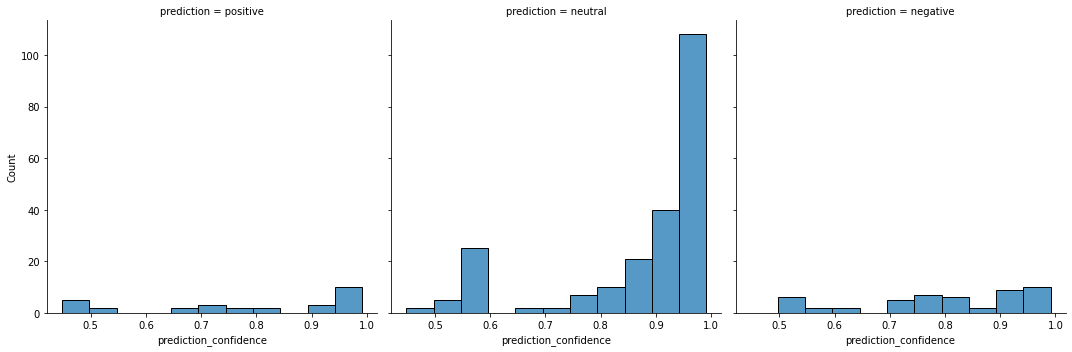

In [433]:
import seaborn as sb
import pandas as pd
sb.displot(pd.DataFrame(predictions),x="prediction_confidence",col="prediction")

Looks like the model is usually only confident about neutral predictions of Andrej Babis (most such predictions have high confidence) and much less confident about the positive and negagtive predictions.

------
## Question 1:

Is this because of the data (positive and negative statements are written in relatively neutral way, compared to the training data), or is it because of the model (model is somehow biasad towards neutral models)?

How could we find out?

-------

Let's select most positive and most negative statements:

------
## Question 2:

These are the statements where the model was most confident about prediction. Is it the same thing as actually being "most positive and most negative".

What would we need to do to get these answers from the model?

-------



In [365]:
print("the most positive: ", max([i for i in predictions if i["prediction"]=="positive"],key=lambda x: x["prediction_confidence"]))
print("the most negative: ", max([i for i in predictions if i["prediction"]=="negative"],key=lambda x: x["prediction_confidence"]))

the most positive:  {'text': 'Je tady fajn 🚴\u200d♀️😂', 'probabilities': {'negative': 0.002989267, 'positive': 0.9914219, 'neutral': 0.0055887965}, 'prediction': 'positive', 'prediction_confidence': 0.9914219}
the most negative:  {'text': 'Už to do zítra nevydržím, tady to máte.', 'probabilities': {'negative': 0.9691094, 'positive': 0.003227884, 'neutral': 0.027662616}, 'prediction': 'negative', 'prediction_confidence': 0.9691094}


Let's look at the overal number of posts that are positive or negative.

We will select a threshold of 0.9 as a threshold, above which we trust the model.
If the confidence is lower, we leave the post unclassified.

<BarContainer object of 4 artists>

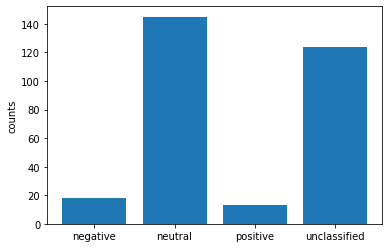

In [437]:
from matplotlib import pyplot as plt
threshold=0.9
only_confident=[i["prediction"] for i in predictions if i["prediction_confidence"]>threshold]
labels,counts=np.unique(only_confident,return_counts=True)
counts=list(counts)
labels=list(labels)
counts+=[len(predictions)-len(only_confident)]
labels+=["unclassified"]
plt.ylabel("counts")
plt.title(name)
plt.bar(labels,counts)

## Question 3
What does this plot say?
Does it match your expectations?
Is the model good enough for us to make conclusions about the author of these posts?

## Excercise 2
In the next cell, see the results for another politician of your choice. Are they different?
Post your resulst (plots, not texts) into the gallery with the name of the politician.

In [ ]:
name="jozko-mrkvicka"
texts=get_texts(name)
predictions=list(tqdm(get_predictions(texts),total=len(texts),desc="processing texts"))

sb.displot(pd.DataFrame(predictions),x="prediction_confidence",col="prediction")
plt.show()

threshold=0.9
only_confident=[i["prediction"] for i in predictions if i["prediction_confidence"]>threshold]
labels,counts=np.unique(only_confident,return_counts=True)
counts=list(counts)
labels=list(labels)
counts+=[len(predictions)-len(only_confident)]
labels+=["unclassified"]
plt.ylabel("counts")
plt.title(name)
plt.bar(labels,counts)
plt.show()

print("the most positive: ", max([i for i in predictions if i["prediction"]=="positive"],key=lambda x: x["prediction_confidence"]))
print("the most negative: ", max([i for i in predictions if i["prediction"]=="negative"],key=lambda x: x["prediction_confidence"]))

# Transfer learning
What if we wanted the model to do something new, e.g.:
 - make the model better
 - do something slightly else (e.g.predict positivity score instead of classification)

As is, the model obviously understands something about czech language.
This knowledge is mostly in the first layers of the model, while the last layers are related more to taking this knowledge and aggregating it to predictions.

So we have two options:

## Fine tuning:
We cut off last few layers of the model, and replace them with the layers that better suits our new needs (e.g. if we wanted more than three classes, we would put a layer that outputs more numbers than 3). If the task doesn't require different architecture, we don't need to do this.

And then we train the whole model again on new data.

Positives:
 - best performance
Negatives:
 - the model is huge and slow
 - the model is hard to train

## Embeddinggs:
We cut off the last few layers of the model, and use the output of the last layer we left there as input to a completely new model we will train on it.

This output of some internal hidden layere of the network is usually called "embedding". Since internal layers are usually large, it often has many dimensions (e.g. for transformers it could be 256 or 512). The hope is, that this embedding reflects high level features that summarize the data, but is yet not specific to the task we trained the model on.

Negatives:
 - likely not as good as retraining whole model

Positives:
 - faster training
 - other good uses of embeddings (e.g. you can search for simmilar records in the dataset by comparing their embeddings mathematically) 
